# SLT-CE-1: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC)
 sampling procedures [1] introduced during the lecture. We will first tackle
 the image reconstruction problem followed by the traveling salesman problem.

## Background (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one
 needs to recover the original through denoising. To do so we will use the
 prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from
 physics as explained in section 8.3.3 of [2]. An undirected graphical
 model is designed to model (i) the adherence of the reconstruction to the
 observed noisy image and (ii) the correlation between neighboring pixels.
 We are interested in recovering a single image, the most likely one, with
 respect to the underlying distribution i.e. we do MAP inference to discover
  the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References
[0] [SLT ](https://ml2.inf.ethz.ch/courses/slt/)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is
the value of the i-th pixel, the Ising model tries to find a denoised image
$x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel
neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding
pixels. In this exercise we consider only the 4 pixel neigbourhood (up,
down, left and right pixels). The undirected probabilistic graphical model
from where the energy function $E(x|y)$ is derived, is explained in more
detail in [2]. Note that $\beta$ denotes the interaction between pixels and is
not to be mistaken for the inverse temperature, which sometimes is also
denoted as $\beta$.

In [95]:
!pip install pathos

 <h2> Setup </h2>

We start by importing necessary python packages.

In [96]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar

# Windows users might experience issues with pathos multiprocessing.
# We only use pathos to accelerate the last cell of section 5.5
# If you are unable to install pathos, you can simply remove the two
# lines below and modify the code in the last cell of section 5.5
# to run in a single process.
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [97]:
import numpy as np
from io import BytesIO

from PIL import Image
import urllib.request

def get_images(size=None, p=0.3):
    """Load image data for denoising

    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]

    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("eth.png")[:,:,0] # Load image
    #img = mpimg.imread("https://github.com/marvin-koch/slt-ce-1/eth.png")[:,:,0] # Load image

    #img = mpimg.imread(Image.open(urllib.request.urlopen("https://github.com/marvin-koch/slt-ce-1/blob/main/eth.png")))
    #response = urllib.request.urlopen("https://raw.githubusercontent.com/marvin-koch/slt-ce-1/main/eth.png")



    # Read the image and load it using matplotlib's imread
    #img = mpimg.imread(((response)))[:,:,0]




    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1

    # Resize image
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1

    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img

    return noisy, img

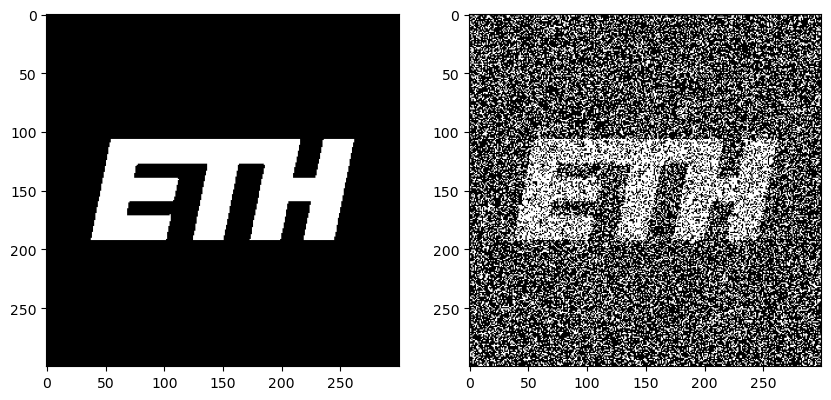

In [98]:
noisy, img = get_images()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: Specific instance of the broader Metropolis-Hastings algorithm, characterized by the symmetry of its proposal distribution denoted as $Q(x' \mid x) = Q(x \mid x')$. This symmetry implies that the probability of proposing a transition from state $x$ to state $x'$ is the same as the probability of proposing a transition from $x'$ to $x$. 

   This symmetry property simplifies the calculation of the acceptance ratio in the Metropolis algorithm. This cancellation results in a streamlined computational process, as the acceptance ratio is solely determined by the ratio of probabilities $\frac{P(x')}{P(x)}$, where $P(x)$ represents the probability of observing state $x$ according to the target distribution.


- **Metropolis-Hastings**:The Metropolis-Hastings algorithm is a Markov chain Monte Carlo (MCMC) method used for sampling from a target probability distribution $\pi(x)$, where $x$ is the state space. It involves the following key formulas:

   Proposal Distribution $Q(x' \mid x)$: 
   This distribution suggests a new state $x'$ given the current state $x$. It can be any distribution that ensures exploration of the state space.

   Acceptance Probability $\alpha(x' \mid x)$: 
   This is the probability of accepting the proposed state $x'$ given the current state $x$. It's defined as:
   $$ \alpha(x' \mid x) = \min \left(1, \frac{\pi(x') Q(x \mid x')}{\pi(x) Q(x' \mid x)} \right) $$
   This formula balances the likelihood of the proposed state with the likelihood of the current state, ensuring that the Markov chain transitions to states that are more probable under the target distribution $\pi(x)$.

   Acceptance or Rejection Step: 
   At each iteration, a proposed state $x'$ is generated from $Q(x' \mid x)$. The proposed state is accepted with probability $\alpha(x' \mid x)$ and rejected otherwise. If accepted, the chain moves to the new state $x'$; otherwise, it remains in the current state $x$.

   The algorithm iteratively generates samples by transitioning between states according to these acceptance probabilities. Over time, the samples produced converge to the desired target distribution $\pi(x)$.

- **Simulated Annealing**:Combines the Metropolis-Hastings algorithm with a cooling schedule for the temperature parameter $T$. It starts with high temperatures, enabling broad exploration of the solution space to prevent premature convergence to local minima. As $T$ gradually decreases, the focus shifts towards exploitation, with the aim of uncovering a global minimum. The acceptance probability for a state with a higher cost follows the Boltzmann distribution.
$\alpha(\Delta E) = \exp\left(-\frac{\Delta E}{T}\right)$



<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums.
    </p>

In [99]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]

    E = 0
    """
    for i in range(height):
        for j in range(width):
            neighbors_sum = img_estimate[max(i-1, 0), j] + img_estimate[min(i+1, height-1), j] + \
                            img_estimate[i, max(j-1, 0)] + img_estimate[i, min(j+1, width-1)]
            E += -0.5 * beta * img_estimate[i, j] * neighbors_sum - mu * img_estimate[i, j] * img_noisy_observation[i, j]

    return E
    """
    for i in range(height):
        for j in range(width):
            neighbors_sum = 0
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            for x, y in neighbors:
                if 0 <= x < height and 0 <= y < width:
                    neighbors_sum += img_estimate[x, y]
            E += -0.5 * beta * (img_estimate[i, j] / 4) * neighbors_sum - (mu * img_estimate[i, j] * img_noisy_observation[i, j])

    return E

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [100]:
assert np.isclose(energy(*get_images()), -146559.5) or np.isclose(energy(*get_images()), -146934.5)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [101]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling

    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width

    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))

        for cnt, idx in enumerate(np.random.permutation(n_pixels)):

            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")

            #
            #
            # Your turn
            #
            #
            i = idx//width
            j = idx % width
            est = estimate[i, j]
            nrg = energy(noisy_img, estimate)
            estimate[i, j] = -1 * est
            newenergy = energy(noisy_img, estimate)
            diff = newenergy - nrg
            if not(diff <= 0 or np.random.rand() < np.exp(-diff / T)):
                estimate[i, j] = est
            #


        energies.append(energy(noisy_img, estimate))

    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [102]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()

    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

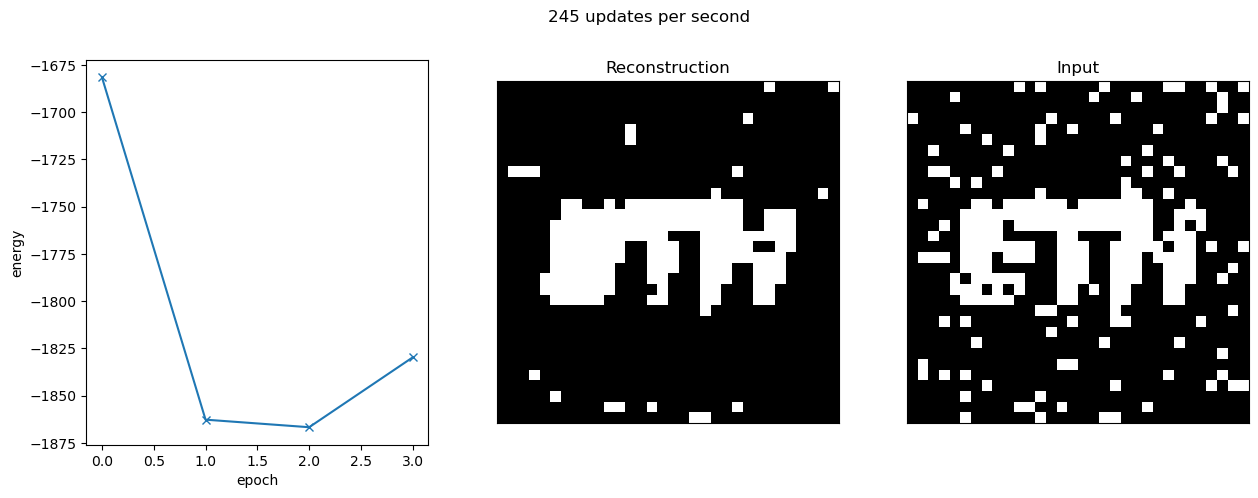

In [103]:
E_metro = evaluate_ising(metropolis, *get_images(size=(32,32), p=0.1), epochs=3)

In [104]:
print(E_metro)

(-1829.75, 0.041015625)


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

*texte en italique*<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

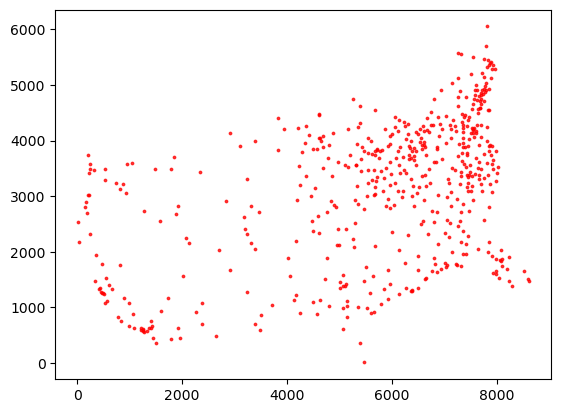

In [106]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [107]:
import numpy as np

def distance(coordinates, route=None):
    """Calculate travel distance.

    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.

    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order

    Returns:
        float: traveled distance in units of kilometers
    """

    if route is not None:
        coordinates = coordinates[route]

    dist = 0
    n = len(coordinates)
    for i in range(n - 1):
        dist += np.linalg.norm(coordinates[i] - coordinates[i+1])

    # Add distance from last city back to the starting city
    dist += np.linalg.norm(coordinates[-1] - coordinates[0])

    # Convert distance from meters to kilometers
    dist /= 1000

    return dist


<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [108]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [109]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates

    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)

    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")

    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)

    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [110]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)

    N = coordinates.shape[0]

    if route is None:
        route = np.random.permutation(N)

    distances = []
    distances.append(distance(coordinates, route))
    
    for e in range(epochs):
        for idx in np.random.permutation(N):
            # i = np.random.randint(0, N, 1)
            route_proposal = route.copy()
            j = idx + 1 if idx < N -1 else 0
            route_proposal[idx], route_proposal[j] = route_proposal[j], route_proposal[idx]

            energy_before = distance(coordinates, route)
            energy_after = distance(coordinates, route_proposal)
            delta_energy = energy_after - energy_before

            if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / T):
                route = route_proposal
                distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

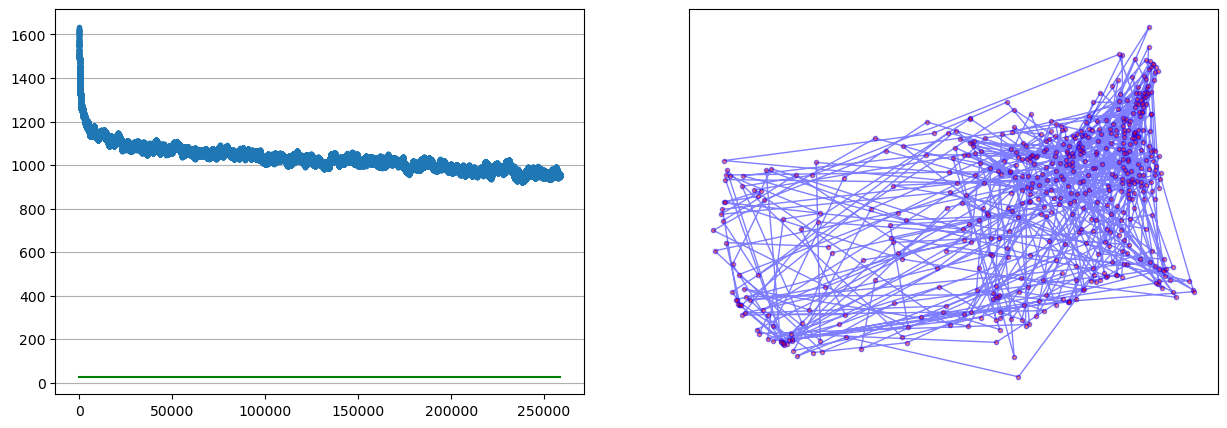

In [111]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [112]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)

    N = coordinates.shape[0]

    if route is None:
        route = np.random.permutation(N)

    distances = []
    distances.append(distance(coordinates, route))


    for e in range(epochs):
        for idx in np.random.permutation(N):
            # i = np.random.randint(0, N, 1)
            new_route = route.copy()
            j = idx + 1 if idx < N -1 else 0
            new_route[idx], new_route[j] = new_route[j], new_route[idx]
            energy_change = distance(coordinates, new_route) - distance(coordinates, route)

            if energy_change < 0 or np.random.rand() < np.exp(-energy_change / T):
                route = new_route.copy()

        T *= eta**e

        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

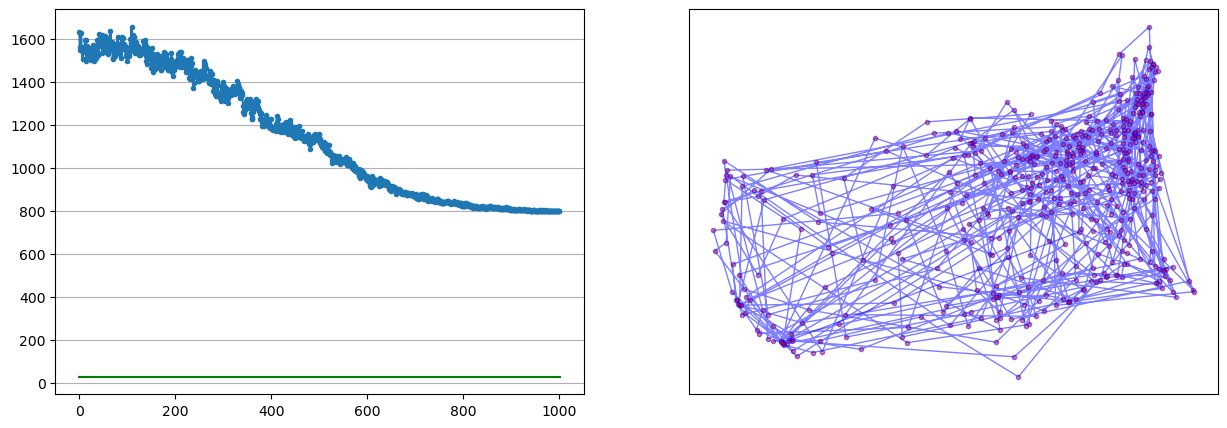

In [113]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [118]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """

    Local energy difference between unflipped and flipped pixel i,j

    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel

    Returns:
        float: local energy difference when pixel i,j is flipped
    """
   
    height, width = estimate.shape
    
    total = 0
    neighborhood = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    for x,y in neighborhood:
        if 0 <= x < height and 0 <= y < width:
            total += estimate[x,y]
            
    
    dE1 = 2 * mu * estimate[i, j] * noisy[i, j]
    dE2 = beta * estimate[i, j] * total /2
    
    dE = dE1 + dE2
    
    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling

    For each epoch, loop over every pixel and attempt flip using local_energy_change

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width

    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))

        for cnt, pix in enumerate(np.random.permutation(n_pixels)):

            #
            #
            # Your turn
            #
            #
            x = pix//width
            y = pix%width
            dE = local_energy_change(noisy_img, estimate, x, y, beta, mu)
            current = estimate[x,y]
            estimate[x, y] = -current
            if not(dE <= 0 or np.random.random() < np.exp(-dE / T)):
                estimate[x,y] = current
 
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        

    return estimate, np.asarray(energies)


<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

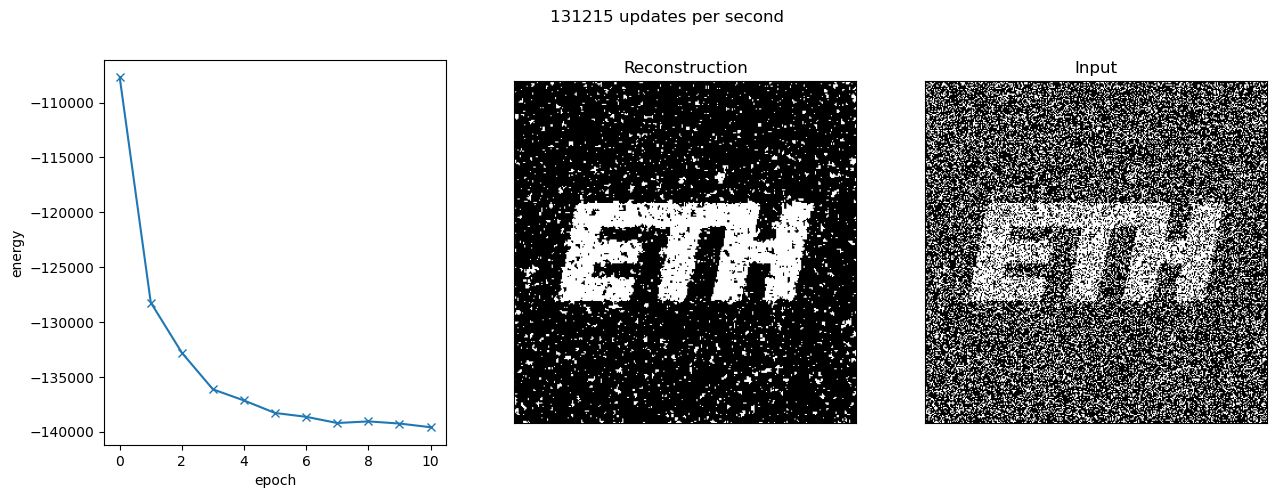

(-139598.75, 0.06994444444444445)

In [119]:
E_local = evaluate_ising(local_metropolis, *get_images(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *get_images(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [120]:
assert E_metro == E_local

In [ ]:
print(E_local)
print(E_metro)

(-1829.75, 0.041015625)
(-1829.75, 0.041015625)


<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [121]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid

    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.

    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.

    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.

    """
    #
    #
    # Your turn
    #
    #

    E = 2*mu*noisy_img
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    neighborhood = (beta/2)*fftconvolve(estimate, kernel, mode="same")*grid

    dE = estimate*grid*(E + neighborhood)
    return dE

In [ ]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling

    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size

    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    #
    #
    # Your turn, definition of grids
    #
    #
    gridzereos = np.zeros_like(estimate)
    gridones = np.ones_like(estimate)

    gridzereos[::2,::2] = 1
    gridones[::2,::2] = 0

    gridzereos[1::2,1::2] = 1
    gridones[1::2,1::2] = 0
    grids=[gridzereos,gridones]


    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))

        for grid in grids:
                #
                #
                # Your turn
                #
                #
                dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
                acceptprob = np.minimum(1, np.exp(-dE/T))
                accept = -((np.random.rand(*acceptprob.shape) < acceptprob).astype(int))*grid
                accept[accept == 0] = 1 
                
                estimate = accept*estimate


        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))

    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

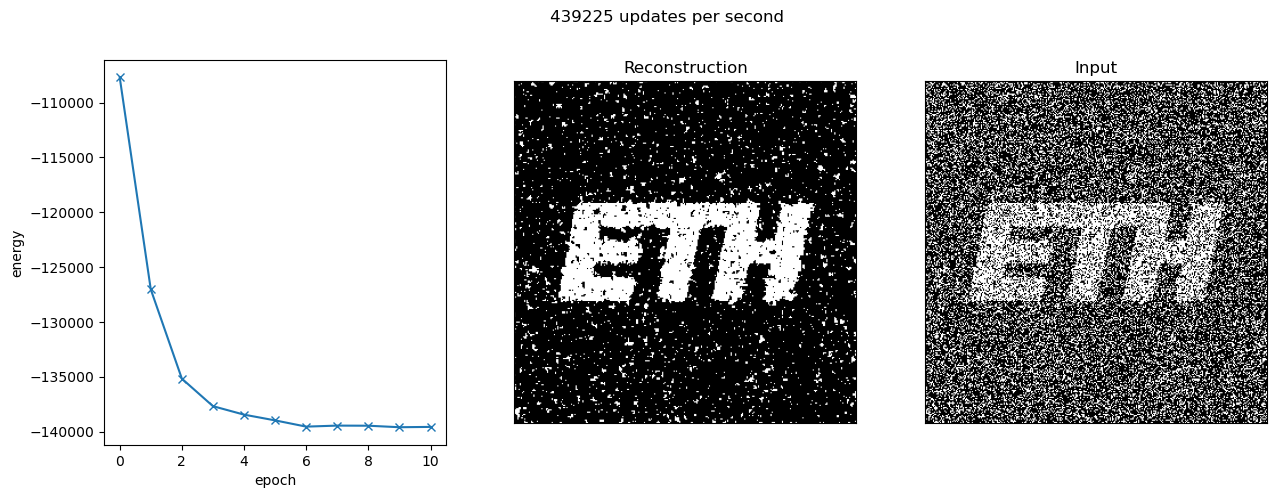

(-139577.5, 0.06714444444444445)

In [122]:
evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

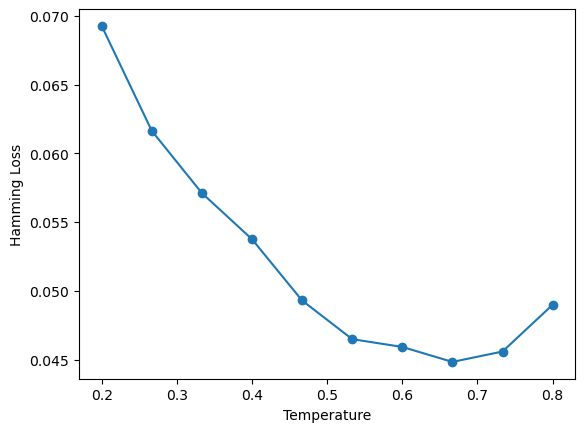

In [123]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

The Hamming Loss describes how well our algorithm is performing. We can see that low temperatures result in high loss, indicating bad performance. This is because low temperature makes our algorithm only exploit without exploring. For temperature t=0.6 we find a good balance between exploitation/exploration. For high temperature values, our algorithm starts to perform badly again because it doesn't exploit enough.

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

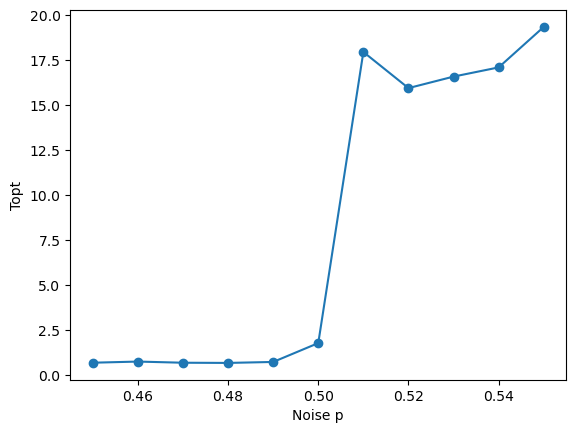

In [124]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *get_images(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)

plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()


High noise requires a T which forces us to explore a lot, thus an optimal value is high. For low noise, we are closer to the true image, which means that we can exploit more. Our optimal T would need to be a low value.

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [127]:
def myfancyalgorithm(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)

    N = coordinates.shape[0]

    if route is None:
        route = np.random.permutation(N)

    distances = []
    distances.append(distance(coordinates, route))


    for e in range(epochs):
        for idx in np.random.permutation(N):
            new_route = route.copy()
            j = np.random.randint(0, N, size=1)
            new_route[idx], new_route[j] = new_route[j], new_route[idx]
            energy_change = distance(coordinates, new_route) - distance(coordinates, route)

            if energy_change < 0 or np.random.rand() < np.exp(-energy_change / T):
                route = new_route.copy()

        T *= eta**e

        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

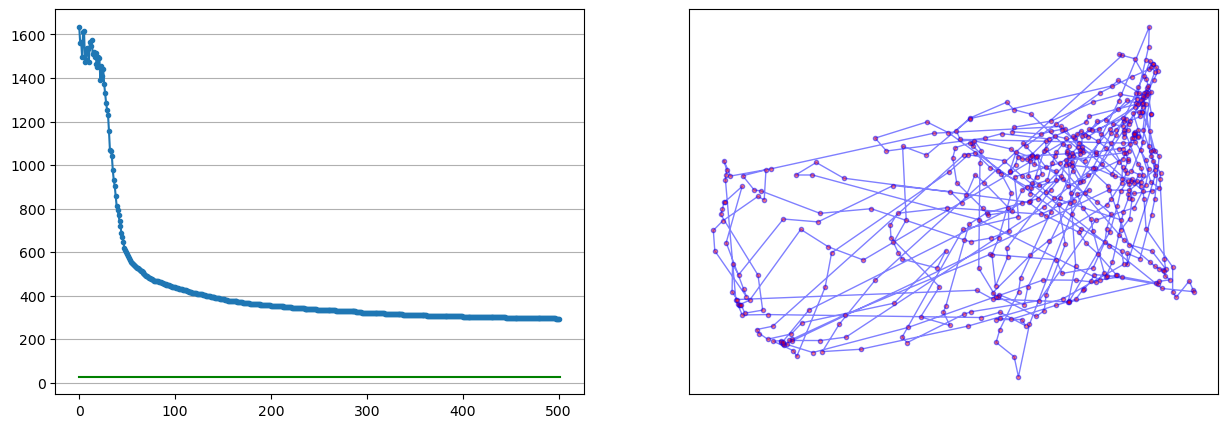

In [129]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.